In [1]:
!pip install bs4
!pip install nltk
!pip install fuzzywuzzy
!pip install wordcloud
!pip install xgboost
!pip install gensim

     |████████████████████████████████| 102kB 21.9MB/s ta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 1.5MB 26.5MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
     |████████████████████████████████| 368kB 26.4MB/s eta 0:00:01
     |████████████████████████████████| 142.8MB 50.5MB/s eta 0:00:01:05.8MB 506kB/s eta 0:03:30.5MB 506kB/s eta 0:03:2344.9MB/s eta 0:00:02         | 85.6MB 46.9MB/s eta 0:00:02███████▏         | 99.1MB 46.9MB/s eta 0:00:01
     |████████████████████████████████| 24.2MB 31.9MB/s eta 0:00:01
     |████████████████████████████████| 71kB 19.6MB/s eta 0:00:01
     |████████████████████████████████| 1.4MB 35.9MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/ab/10/93/5cff86f5b721d77edaecc2995

In [2]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from statistics import mean
from nltk.stem import WordNetLemmatizer
import nltk
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score
from fuzzywuzzy import fuzz
import matplotlib as mpl
import seaborn as sns
from gensim.models import word2vec

# Custom settings to view all column names and their data in the output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

nltk.download('wordnet')

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jupyterlab/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
#repr(string)

In [4]:
data = pd.read_csv('generic_tweets.txt', sep  = "," )

In [5]:
data['class'].value_counts(dropna = False)

4    100000
0    100000
Name: class, dtype: int64

Replacing 4 with 1 for convenient working

In [6]:
data['class'].replace(4,1, inplace = True)

In [7]:
data['query'].value_counts(dropna = False)

NO_QUERY    200000
Name: query, dtype: int64

In [8]:
#Since query column consists of only 'No_QUERY', removing it from data
data.drop('query', axis = 1, inplace = True)

In [9]:
data.head()

,class,id,date,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


## Text processing of tweets for further working

Removal of stop words: 
The goal of stop words is to remove unnecessary words (reduces storage complexities) but the available lists of stop words, the one from the NLTK library for instance,it has words that potentially convey negative sentiments such as: not, don’t, hasn’t…. but for sentiment analysis problem we want to keep negative words.

From the file stop_words.txt, removing negative sentiment words

In [10]:
stop_words = pd.read_csv('stop_words.txt', names = ['stop words'])
stop_words_list = stop_words.iloc[:,0].tolist()

words_to_remove = ['cannot', "can't", 'arent', "didn't", "doesn't", "don't", "hasn't", "haven't", "no", "not", "shouldn't",
                  "wasnt", "werent", "wouldnt"]

for word in words_to_remove:
    stop_words_list.remove(word)

In [11]:
#removing html tags and attributes

def remove_html_tags(input_text):
    output_text = BeautifulSoup(input_text).get_text()
    return output_text


# removal of URLS, hashtags, usernames and mentions beacuse they do not weigh in sentiment analysis

def remove_urls_hash_tags(input_text):
    output_text = re.sub('@[A-Z0-9a-z]+|#[A-Z0-9a-z]+|http\S+', ' ', input_text)
    return output_text

#replacing emoticons with 'positive' (positive emotion) and 'negative' (negative emotion)

happy_emo = [':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', ';D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)', '<3']
sad_emo = [':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
               ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
               ':c', ':{', '>:\\', ';(']

def replace_emoticons(input_text):
    words = input_text.split()
    output_text = ''

    for word in words:
        count = 0
        for pos_emo in happy_emo:
            if word == pos_emo:
                output_text = output_text + ' '+ 'posemo'  #posemo in place of happy emoticon
                count +=1
                
        for neg_emo in sad_emo:
            if word == neg_emo:
                output_text = output_text + ' '+ 'negemo' #negemo in place of sad emotion
                count +=1
                
        if count == 0:
            output_text = output_text + ' ' + word
    
    return output_text 


def preprocess_text(input_text):
    output_text = ' '
    sentence = remove_urls_hash_tags(input_text)  #urls, hashtags, mentions &tags
    sentence = replace_emoticons(sentence)  #replace emoticons
    
    #convert to lower case (words like GOOD and good should be considered same)
    lower_case = sentence.lower()    #lowercase
    lower_case = re.sub('\.|\,|\?|\!|-|_','', lower_case)
    
    #punctuations add noise and do not contribute to the sentiments
    
    punctuation_removal = lower_case.translate(str.maketrans('', '', string.punctuation))
   
    split_list = punctuation_removal.split()
    
    #removal of stopwords from the list prepared in the cell above
    for index, word in enumerate(split_list):    #removal of stopwords
        if word in stop_words_list:
            split_list.remove(word)
    sentence = split_list
    
    #lemmatizing words so that all words are in their base form (i.e predicts, predict & predicted should be represented as predict)
    
    lemmatizer=WordNetLemmatizer()
    words_lem = [lemmatizer.lemmatize(word) for word in sentence] 
    
    #removing single letter words
    words_lem = [word for word in words_lem if (len(word)>1)]
    
    output_text = output_text.join(words_lem)
    
    #removing anything apart from words and numbers: final processing
    output_text = re.sub('([^A-Z0-9a-z\s]+)', ' ', output_text)    
    
    return output_text

In [12]:
data['tweets'] = data['text'].apply(lambda x: preprocess_text(x)).copy()

In [13]:
data['tweets'].head()

0    awww bummer shoulda david carr third day do posemo                    
1    upset he cant update facebook texting and cry result school today blah
2    dived time ball managed save 50 the rest out bound                    
3    whole body feel itchy like on fire                                    
4    no not behaving mad am here cant you all over                         
Name: tweets, dtype: object

## Exploratory Analysis for generic tweets file
Word Cloud:
A word cloud represents word usage in a document by resizing individual words proportionally to its frequency, and then presenting them in random arrangement.

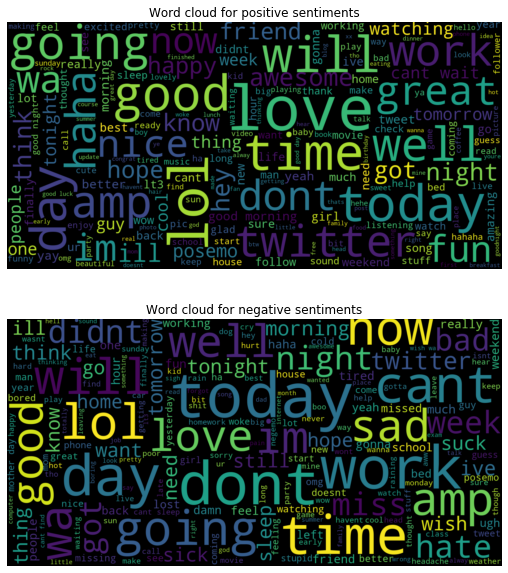

<Figure size 432x288 with 0 Axes>

In [14]:
#Word cloud for Positive Tweets
generic_tweets = data['tweets'][data['class']==1]
tweets_string = []
for t in generic_tweets:
    tweets_string.append(t)
tweets_string = pd.Series(tweets_string).str.cat(sep=' ')


wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tweets_string)
fig, axes = plt.subplots(2, 1, figsize = (12,10))
axes[0].set_title('Word cloud for positive sentiments')
axes[0].imshow(wordcloud, interpolation="bilinear")
axes[0].axis("off")


generic_tweets = data['tweets'][data['class'] == 0]
tweets_string = []
for t in generic_tweets:
    tweets_string.append(t)
tweets_string = pd.Series(tweets_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tweets_string)

axes[1].set_title('Word cloud for negative sentiments')
axes[1].imshow(wordcloud, interpolation="bilinear")
axes[1].axis("off")

plt.show()
plt.savefig('Word Clouds.png')

**Discussion:**

Some words in both the word clouds clearly represent their respective emotion. For example:
Positve emotion words: good, haha, love, nice, great, well, posemo
Negative emotion words: sad, still, cant, dont, hate

However, both the word clouds have common prominent words like today, amp which might represent common subject of tweets  

## Model Preparation and Implementation on Generic Tweets data

Feature extraction
1. Bag of words
2. TF-IDF

Models are trained on generic tweet's vocabulary and then sentiments of canadian election tweets are preidcted using the best model.This give us insight on the model performance on unseen data

In [17]:
#shuffling data because classes are not shuffled first 100000 are 0's and next 100000 1's
data = data.sample(frac=1).reset_index(drop=True)

In [18]:
X = data['tweets']
y = data['class']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [20]:
X_train

21269     man hungry cant wait get eat ooh and kick more butt mario kart hopefully
187660    now                                                                     
774       no wa talking me                                                        
184577    no power downtown hope not blackout                                     
37127                                                                             
         ..                                                                       
119879    part the lie dramanow priceless                                         
103694                                                                            
131932    well twitter mobile aint working no tiesto livetwitterreport            
146867    want go rollercoaster carmen                                            
121958    great veggie lasagna happy marathon monday boston folk                  
Name: tweets, Length: 140000, dtype: object

Using count vectorizer for bag of words and tfidf vectorizer for TFIDF. 

**Parameters for TFIDF and Bag of words:**
1. max_fetaures are set to 2000 for reduce computation time and have uniform number of features for models.
2. strip_accents: to replace any special character with ascii representation

In [21]:
#sparse matrix for bag of words
count_vectorizer = CountVectorizer(max_features = 2000, strip_accents = 'ascii')
count_vectorizer.fit(X)
feature_names = count_vectorizer.get_feature_names()
bow_train = count_vectorizer.transform(X_train)
bow_test = count_vectorizer.transform(X_test)

In [22]:
#sparse matrix for TFIDF
tfidf_vectorizer = TfidfVectorizer(max_features = 2000, strip_accents = 'ascii')
tfidf_vectorizer.fit(X)
tfidf_train = tfidf_vectorizer.transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [23]:
f_train = hstack([tfidf_train, bow_train])
f_test = hstack([tfidf_test, bow_test])

In [24]:
f_train.shape

(140000, 4000)

In [25]:
f_test.shape

(60000, 4000)

**Evaluation metric:**
classification report is measured for all models but for comparing the results accuracy and f-measure is considered (precision and recall have similar values for all models, therefore it's suitable to consider f-measure for evaluation)

Further,
In classification report, **macro-average f1 score** is considered for evaluation because macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally). Also, we have equal sentiment polarity in dataset. Therefore macro average is a better choice.

In [26]:
train_accuracy = []
test_accuracy = []
train_f_measure = []
test_f_measure = []

## Model 1: Logistic Regression

Parameters chosen:

1. **C** = 0.01; because smaller values specify stronger regularization. (Regularization is a very important technique to prevent overfitting) 
2. **solver** = saga; because it is faster than other solvers for large datasets, when both the number of samples and the number of features are large.
3. **penalty** = l2; because it addresses the multicollinearity problem by constraining the coefficient norm and keeping all the variables.

In [27]:
model_name = 'Logistic_regression - Bag of Words'
model_logistic_regression_bow = LogisticRegression(C = 0.01, solver = 'saga', penalty = 'l2')
model_logistic_regression_bow.fit(bow_train, y_train)

#evaluation on test
accuracy_test_lr_bow = model_logistic_regression_bow.score(bow_test, y_test)
#test_accuracy.append(accuracy_test)
print("Accuracy on test set for model- ", model_name, "is", round(accuracy_test_lr_bow,2)*100 , "%")

predictions = model_logistic_regression_bow.predict(bow_test)
conf_matrix_logistic_regression = confusion_matrix(y_test,predictions,labels=[0, 1])
print ("Confusion matrix: \n", conf_matrix_logistic_regression)

classification_report_ = classification_report(y_test,predictions, output_dict=True)
class_report_logistic_regression = pd.DataFrame(classification_report_).transpose()
f1_score_lr_bow = class_report_logistic_regression.loc['macro avg','f1-score']
#test_f_measure.append(f1_score_test)
print("Precision, recall and F1_score: \n", class_report_logistic_regression)
print("Macro-average score on test set: ", f1_score_lr_bow)

#evaluation on training set to check that model is not overfitting
accuracy_train = model_logistic_regression_bow.score(bow_train, y_train)
#train_accuracy.append(accuracy_train)
print("Accuracy on train set for model- ", model_name, "is", round(accuracy_train,2)*100 , "%")

predictions_train = model_logistic_regression_bow.predict(bow_train)
classification_report_ = classification_report(y_train,predictions_train, output_dict=True)
class_report_logistic_regression_train = pd.DataFrame(classification_report_).transpose()
f1_score_train = class_report_logistic_regression_train.loc['macro avg','f1-score']
#train_f_measure.append(f1_score_train)
print("Macro-average score on train set: ", f1_score_train)

Accuracy on test set for model-  Logistic_regression - Bag of Words is 74.0 %
Confusion matrix: 
 [[21142  8785]
 [ 6526 23547]]
Precision, recall and F1_score: 
               precision    recall  f1-score  support
0             0.764132   0.706452  0.734161  29927.0
1             0.728288   0.782995  0.754651  30073.0
micro avg     0.744817   0.744817  0.744817  60000.0
macro avg     0.746210   0.744724  0.744406  60000.0
weighted avg  0.746166   0.744817  0.744431  60000.0
Macro-average score on test set:  0.7444060105486565
Accuracy on train set for model-  Logistic_regression - Bag of Words is 75.0 %
Macro-average score on train set:  0.7490010118794654


In [28]:
model_name = 'Logistic_regression - tfidf'
model_logistic_regression_tfidf = LogisticRegression(C = 0.01, solver = 'saga', penalty = 'l2')
model_logistic_regression_tfidf.fit(tfidf_train, y_train)

#evaluation on test
accuracy_test_lr_tfidf = model_logistic_regression_tfidf.score(tfidf_test, y_test)
#test_accuracy.append(accuracy_test)
print("Accuracy on test set for model- ", model_name, "is", round(accuracy_test_lr_tfidf,2)*100 , "%")

predictions = model_logistic_regression_tfidf.predict(tfidf_test)
conf_matrix_logistic_regression = confusion_matrix(y_test,predictions,labels=[0, 1])
print ("Confusion matrix: \n", conf_matrix_logistic_regression)

classification_report_ = classification_report(y_test,predictions, output_dict=True)
class_report_logistic_regression = pd.DataFrame(classification_report_).transpose()
f1_score_lr_tfidf = class_report_logistic_regression.loc['macro avg','f1-score']
#test_f_measure.append(f1_score_test)
print("Precision, recall and F1_score: \n", class_report_logistic_regression)
print("Macro-average score on test set: ", f1_score_lr_tfidf)

#evaluation on training set to check that model is not overfitting
accuracy_train = model_logistic_regression_tfidf.score(tfidf_train, y_train)
#train_accuracy.append(accuracy_train)
print("Accuracy on train set for model- ", model_name, "is", round(accuracy_train,2)*100 , "%")

predictions_train = model_logistic_regression_tfidf.predict(tfidf_train)
classification_report_ = classification_report(y_train,predictions_train, output_dict=True)
class_report_logistic_regression_train = pd.DataFrame(classification_report_).transpose()
f1_score_train = class_report_logistic_regression_train.loc['macro avg','f1-score']
#train_f_measure.append(f1_score_train)
print("Macro-average score on train set: ", f1_score_train)

Accuracy on test set for model-  Logistic_regression - tfidf is 74.0 %
Confusion matrix: 
 [[21410  8517]
 [ 7273 22800]]
Precision, recall and F1_score: 
               precision    recall  f1-score  support
0             0.746435   0.715407  0.730592  29927.0
1             0.728039   0.758155  0.742792  30073.0
micro avg     0.736833   0.736833  0.736833  60000.0
macro avg     0.737237   0.736781  0.736692  60000.0
weighted avg  0.737215   0.736833  0.736707  60000.0
Macro-average score on test set:  0.736692017401895
Accuracy on train set for model-  Logistic_regression - tfidf is 74.0 %
Macro-average score on train set:  0.7392279075663879


**Discussion:**

Since accuracies and f1-scores for training set and test are nearly same, it is not overfitting. Hence are parameters for models works fine and can be used for new datasets for sentiment analysis

## Model 2: Naive Bayes

**Model chosen:** Multinomial bayes..this is mostly used for document classification problem. The features/predictors used by the classifier are the frequency of the words present in the document.

Hyperparameter alpha is used for smoothening of data. Using alpha = 1 (default value)

In [29]:
model_name = 'Naive Bayes- Bag of words'
model_naive_bayes_bow = MultinomialNB(alpha = 1)
model_naive_bayes_bow.fit(bow_train, y_train)

#evaluation on test
accuracy_test_nb_bow = model_naive_bayes_bow.score(bow_test, y_test)
#test_accuracy.append(accuracy_test)
print("Accuracy on test set for model- ", model_name, "is", round(accuracy_test_nb_bow,2)*100 , "%")

predictions = model_naive_bayes_bow.predict(bow_test)
conf_matrix_naive_bayes = confusion_matrix(y_test,predictions,labels=[0, 1])
print ("Confusion matrix: \n", conf_matrix_naive_bayes)

classification_report_ = classification_report(y_test,predictions, output_dict=True)
class_report_naive_bayes = pd.DataFrame(classification_report_).transpose()
f1_score_nb_bow = class_report_naive_bayes.loc['macro avg','f1-score']
#test_f_measure.append(f1_score_test_nb_bow)
print("Precision, recall and F1_score: \n", class_report_naive_bayes)
print("Macro-average score on test set: ", f1_score_nb_bow)

#evaluation on training set to check that model is not overfitting
accuracy_train = model_naive_bayes_bow.score(bow_train, y_train)
#train_accuracy.append(accuracy_train)
print("Accuracy on train set for model- ", model_name, "is", round(accuracy_train,2)*100 , "%")

predictions_train = model_naive_bayes_bow.predict(bow_train)
classification_report_ = classification_report(y_train,predictions_train, output_dict=True)
class_report_naive_bayes_train = pd.DataFrame(classification_report_).transpose()
f1_score_train = class_report_naive_bayes_train.loc['macro avg','f1-score']
#train_f_measure.append(f1_score_train)
print("Macro-average score on train set: ", f1_score_train)

Accuracy on test set for model-  Naive Bayes- Bag of words is 74.0 %
Confusion matrix: 
 [[22469  7458]
 [ 8033 22040]]
Precision, recall and F1_score: 
               precision    recall  f1-score  support
0             0.736640   0.750794  0.743650  29927.0
1             0.747169   0.732883  0.739957  30073.0
micro avg     0.741817   0.741817  0.741817  60000.0
macro avg     0.741905   0.741838  0.741803  60000.0
weighted avg  0.741918   0.741817  0.741799  60000.0
Macro-average score on test set:  0.7418034670144091
Accuracy on train set for model-  Naive Bayes- Bag of words is 75.0 %
Macro-average score on train set:  0.7506853593138236


In [30]:
model_name = 'Naive Bayes- TFIDF'
model_naive_bayes_tfidf = MultinomialNB(alpha = 1)
model_naive_bayes_tfidf.fit(tfidf_train, y_train)

#evaluation on test
accuracy_test_nb_tfidf = model_naive_bayes_tfidf.score(tfidf_test, y_test)
#test_accuracy.append(accuracy_test)
print("Accuracy on test set for model- ", model_name, "is", round(accuracy_test_nb_tfidf,2)*100 , "%")

predictions = model_naive_bayes_tfidf.predict(tfidf_test)
conf_matrix_naive_bayes = confusion_matrix(y_test,predictions,labels=[0, 1])
print ("Confusion matrix: \n", conf_matrix_naive_bayes)

classification_report_ = classification_report(y_test,predictions, output_dict=True)
class_report_naive_bayes = pd.DataFrame(classification_report_).transpose()
f1_score_nb_tfidf = class_report_naive_bayes.loc['macro avg','f1-score']
#test_f_measure.append(f1_score_test_nb_bow)
print("Precision, recall and F1_score: \n", class_report_naive_bayes)
print("Macro-average score on test set: ", f1_score_nb_tfidf)

#evaluation on training set to check that model is not overfitting
accuracy_train = model_naive_bayes_tfidf.score(tfidf_train, y_train)
#train_accuracy.append(accuracy_train)
print("Accuracy on train set for model- ", model_name, "is", round(accuracy_train,2)*100 , "%")

predictions_train = model_naive_bayes_tfidf.predict(tfidf_train)
classification_report_ = classification_report(y_train,predictions_train, output_dict=True)
class_report_naive_bayes_train = pd.DataFrame(classification_report_).transpose()
f1_score_train = class_report_naive_bayes_train.loc['macro avg','f1-score']
#train_f_measure.append(f1_score_train)
print("Macro-average score on train set: ", f1_score_train)

Accuracy on test set for model-  Naive Bayes- TFIDF is 74.0 %
Confusion matrix: 
 [[22135  7792]
 [ 7894 22179]]
Precision, recall and F1_score: 
               precision    recall  f1-score  support
0             0.737121   0.739633  0.738375  29927.0
1             0.740015   0.737505  0.738758  30073.0
micro avg     0.738567   0.738567  0.738567  60000.0
macro avg     0.738568   0.738569  0.738567  60000.0
weighted avg  0.738572   0.738567  0.738567  60000.0
Macro-average score on test set:  0.738566526073554
Accuracy on train set for model-  Naive Bayes- TFIDF is 75.0 %
Macro-average score on train set:  0.7489751481539988


**Discussion:**

Since accuracies and f1-scores for training set and test are nearly same, it is not overfitting. Hence are parameter alpha = 1 for model works fine and can be used for new datasets for sentiment analysis

## Model 3: kNN Classifer 

Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

**Parameters:**
1. n_neighnors = 5 (default)
2. algorithm = brute_force because of sparse input

In [31]:
model_name = 'KNN Classifier - Bag of words'
model_KNN_bow = KNeighborsClassifier(n_neighbors=5, algorithm = 'brute')
model_KNN_bow.fit(bow_train, y_train)

#evaluation on test
accuracy_test_KNN_bow = model_KNN_bow.score(bow_test, y_test)
#test_accuracy.append(accuracy_test)
print("Accuracy on test set for model- ", model_name, "is", round(accuracy_test_KNN_bow,2)*100 , "%")

predictions = model_KNN_bow.predict(bow_test)
conf_matrix_KNN = confusion_matrix(y_test,predictions,labels=[0, 1])
print ("Confusion matrix: \n", conf_matrix_KNN)

classification_report_ = classification_report(y_test,predictions, output_dict=True)
class_report_KNN = pd.DataFrame(classification_report_).transpose()
f1_score_KNN_bow = class_report_KNN.loc['macro avg','f1-score']
#test_f_measure.append(f1_score_test)
print("Precision, recall and F1_score: \n", class_report_KNN)
print("Macro-average score on test set: ", f1_score_KNN_bow)

#evaluation on training set to check that model is not overfitting
accuracy_train = model_KNN_bow.score(bow_train, y_train)
#train_accuracy.append(accuracy_train)
print("Accuracy on train set for model- ", model_name, "is", round(accuracy_train,2)*100 , "%")

predictions_train = model_KNN_bow.predict(bow_train)
classification_report_ = classification_report(y_train,predictions_train, output_dict=True)
class_report_KNN_train = pd.DataFrame(classification_report_).transpose()
f1_score_train = class_report_KNN_train.loc['macro avg','f1-score']
#train_f_measure.append(f1_score_train)
print("Macro-average score on train set: ", f1_score_train)

Accuracy on test set for model-  KNN Classifier - Bag of words is 67.0 %
Confusion matrix: 
 [[17150 12777]
 [ 6782 23291]]
Precision, recall and F1_score: 
               precision    recall  f1-score  support
0             0.716614   0.573061  0.636848  29927.0
1             0.645752   0.774482  0.704283  30073.0
micro avg     0.674017   0.674017  0.674017  60000.0
macro avg     0.681183   0.673772  0.670566  60000.0
weighted avg  0.681097   0.674017  0.670648  60000.0
Macro-average score on test set:  0.6705656699297433
Accuracy on train set for model-  KNN Classifier - Bag of words is 77.0 %
Macro-average score on train set:  0.7691391623922927


In [32]:
model_name = 'KNN Classifier- TFIDF'
model_KNN_tfidf = KNeighborsClassifier(n_neighbors=5, algorithm = 'brute')
model_KNN_tfidf.fit(tfidf_train, y_train)

#evaluation on test
accuracy_test_KNN_tfidf = model_KNN_tfidf.score(tfidf_test, y_test)
#test_accuracy.append(accuracy_test)
print("Accuracy on test set for model- ", model_name, "is", round(accuracy_test_KNN_tfidf,2)*100 , "%")

predictions = model_KNN_tfidf.predict(tfidf_test)
conf_matrix_KNN = confusion_matrix(y_test,predictions,labels=[0, 1])
print ("Confusion matrix: \n", conf_matrix_KNN)

classification_report_ = classification_report(y_test,predictions, output_dict=True)
class_report_KNN = pd.DataFrame(classification_report_).transpose()
f1_score_KNN_tfidf = class_report_KNN.loc['macro avg','f1-score']
#test_f_measure.append(f1_score_test_nb_bow)
print("Precision, recall and F1_score: \n", class_report_naive_bayes)
print("Macro-average score on test set: ", f1_score_KNN_tfidf)

#evaluation on training set to check that model is not overfitting
accuracy_train = model_KNN_tfidf.score(tfidf_train, y_train)
#train_accuracy.append(accuracy_train)
print("Accuracy on train set for model- ", model_name, "is", round(accuracy_train,2)*100 , "%")

predictions_train = model_KNN_tfidf.predict(tfidf_train)
classification_report_ = classification_report(y_train,predictions_train, output_dict=True)
class_report_naive_bayes_train = pd.DataFrame(classification_report_).transpose()
f1_score_train = class_report_naive_bayes_train.loc['macro avg','f1-score']
#train_f_measure.append(f1_score_train)
print("Macro-average score on train set: ", f1_score_train)

Accuracy on test set for model-  KNN Classifier- TFIDF is 64.0 %
Confusion matrix: 
 [[15284 14643]
 [ 6823 23250]]
Precision, recall and F1_score: 
               precision    recall  f1-score  support
0             0.737121   0.739633  0.738375  29927.0
1             0.740015   0.737505  0.738758  30073.0
micro avg     0.738567   0.738567  0.738567  60000.0
macro avg     0.738568   0.738569  0.738567  60000.0
weighted avg  0.738572   0.738567  0.738567  60000.0
Macro-average score on test set:  0.635813828132998
Accuracy on train set for model-  KNN Classifier- TFIDF is 76.0 %
Macro-average score on train set:  0.7538837280507544


**Discussion:**

KNN model seems to be slightly overfitted: comparing test accuracy(67%) and train accuracy(77%)

Accuracy and f1-score for both the cases (TFIDF and Bag of words) is lesser than Naive Bayes and Logistic regression metrics. 
Also, KNN is computationally slower than the other two models


## Model 4: Support Vector Machine

Support Vector Machines (SVMs) work well with high dimensional spaces and are memory efficient.

Using RBF kernel for SVMs: which uses non-linear hyperplane. gamma is a parameter for non linear hyperplanes. The higher the gamma value it tries to exactly fit the training data set
Since we have lot of features, it won't be ideal to take linear plane for approximation

In [33]:
model_name = 'SVM- Bag of words'
model_SVM_bow = SVC(gamma = 'auto', cache_size = 1000)
model_SVM_bow.fit(bow_train, y_train)

#evaluation on test
accuracy_test_SVM_bow = model_SVM_bow.score(bow_test, y_test)
#test_accuracy.append(accuracy_test)
print("Accuracy on test set for model- ", model_name, "is", round(accuracy_test_SVM_bow,2)*100 , "%")

predictions = model_SVM_bow.predict(bow_test)
conf_matrix_SVM = confusion_matrix(y_test,predictions,labels=[0, 1])
print ("Confusion matrix: \n", conf_matrix_SVM)

classification_report_ = classification_report(y_test,predictions, output_dict=True)
class_report_SVM = pd.DataFrame(classification_report_).transpose()
f1_score_SVM_bow = class_report_SVM.loc['macro avg','f1-score']
#test_f_measure.append(f1_score_test_nb_bow)
print("Precision, recall and F1_score: \n", class_report_SVM)
print("Macro-average score on test set: ", f1_score_SVM_bow)

#evaluation on training set to check that model is not overfitting
accuracy_train = model_SVM_bow.score(bow_train, y_train)
#train_accuracy.append(accuracy_train)
print("Accuracy on train set for model- ", model_name, "is", round(accuracy_train,2)*100 , "%")

predictions_train = model_SVM_bow.predict(bow_train)
classification_report_ = classification_report(y_train,predictions_train, output_dict=True)
class_report_SVM_train = pd.DataFrame(classification_report_).transpose()
f1_score_train = class_report_SVM_train.loc['macro avg','f1-score']
#train_f_measure.append(f1_score_train)
print("Macro-average score on train set: ", f1_score_train)

Accuracy on test set for model-  SVM- Bag of words is 70.0 %
Confusion matrix: 
 [[17825 12102]
 [ 5772 24301]]
Precision, recall and F1_score: 
               precision    recall  f1-score  support
0             0.755393   0.595616  0.666056  29927.0
1             0.667555   0.808067  0.731121  30073.0
micro avg     0.702100   0.702100  0.702100  60000.0
macro avg     0.711474   0.701842  0.698589  60000.0
weighted avg  0.711367   0.702100  0.698668  60000.0
Macro-average score on test set:  0.6985886773156504
Accuracy on train set for model-  SVM- Bag of words is 70.0 %
Macro-average score on train set:  0.7007571569858185


In [34]:
model_name = 'SVM- TFIDF'
model_SVM_tfidf = SVC(gamma = 'auto', cache_size = 1000)
model_SVM_tfidf.fit(tfidf_train, y_train)

#evaluation on test
accuracy_test_SVM_tfidf = model_SVM_tfidf.score(tfidf_test, y_test)
#test_accuracy.append(accuracy_test)
print("Accuracy on test set for model- ", model_name, "is", round(accuracy_test_SVM_tfidf,2)*100 , "%")

predictions = model_SVM_tfidf.predict(tfidf_test)
conf_matrix_SVM = confusion_matrix(y_test,predictions,labels=[0, 1])
print ("Confusion matrix: \n", conf_matrix_SVM)

classification_report_ = classification_report(y_test,predictions, output_dict=True)
class_report_SVM = pd.DataFrame(classification_report_).transpose()
f1_score_SVM_tfidf = class_report_SVM.loc['macro avg','f1-score']
#test_f_measure.append(f1_score_test_nb_bow)
print("Precision, recall and F1_score: \n", class_report_SVM)
print("Macro-average score on test set: ", f1_score_SVM_tfidf)

#evaluation on training set to check that model is not overfitting
accuracy_train = model_SVM_tfidf.score(tfidf_train, y_train)
#train_accuracy.append(accuracy_train)
print("Accuracy on train set for model- ", model_name, "is", round(accuracy_train,2)*100 , "%")

predictions_train = model_SVM_tfidf.predict(tfidf_train)
classification_report_ = classification_report(y_train,predictions_train, output_dict=True)
class_report_SVM_train = pd.DataFrame(classification_report_).transpose()
f1_score_train = class_report_SVM_train.loc['macro avg','f1-score']
#train_f_measure.append(f1_score_train)
print("Macro-average score on train set: ", f1_score_train)

Accuracy on test set for model-  SVM- TFIDF is 67.0 %
Confusion matrix: 
 [[26427  3500]
 [16486 13587]]
Precision, recall and F1_score: 
               precision    recall  f1-score  support
0             0.615827   0.883049  0.725618  29927.0
1             0.795166   0.451801  0.576209  30073.0
micro avg     0.666900   0.666900  0.666900  60000.0
macro avg     0.705497   0.667425  0.650913  60000.0
weighted avg  0.705715   0.666900  0.650731  60000.0
Macro-average score on test set:  0.6509132219106187
Accuracy on train set for model-  SVM- TFIDF is 67.0 %
Macro-average score on train set:  0.6522415027467428


Since accuracies and f1-score are almost same on test and train data, the model is not overfitting

## Model 5: Decision Trees

Decision Trees can be useful for this case, as data to be trained as equal number of samples for both classes.

Using default parameters for decision trees

In [35]:
## Model 4: Decision Trees
model_name = 'Decision Trees- Bag of words'
model_decision_tree_bow = DecisionTreeClassifier()
model_decision_tree_bow.fit(bow_train, y_train)

#evaluation on test
accuracy_test_dt_bow = model_decision_tree_bow.score(bow_test, y_test)
#test_accuracy.append(accuracy_test)
print("Accuracy on test set for model- ", model_name, "is", round(accuracy_test_dt_bow,2)*100 , "%")

predictions = model_decision_tree_bow.predict(bow_test)
conf_matrix_decision_tree = confusion_matrix(y_test,predictions,labels=[0, 1])
print ("Confusion matrix: \n", conf_matrix_decision_tree)

classification_report_ = classification_report(y_test,predictions, output_dict=True)
class_report_decision_tree = pd.DataFrame(classification_report_).transpose()
f1_score_dt_bow = class_report_decision_tree.loc['macro avg','f1-score']
#test_f_measure.append(f1_score_)
print("Precision, recall and F1_score: \n", class_report_decision_tree)
print("Macro-average score on test set: ", f1_score_dt_bow)

#evaluation on training set to check that model is not overfitting
accuracy_train = model_decision_tree_bow.score(bow_train, y_train)
#train_accuracy.append(accuracy_train)
print("Accuracy on train set for model- ", model_name, "is", round(accuracy_train,2)*100 , "%")

predictions_train = model_decision_tree_bow.predict(bow_train)
classification_report_ = classification_report(y_train,predictions_train, output_dict=True)
class_report_decision_tree_train = pd.DataFrame(classification_report_).transpose()
f1_score_train = class_report_decision_tree_train.loc['macro avg','f1-score']
#train_f_measure.append(f1_score_train)
print("Macro-average score on train set: ", f1_score_train)

Accuracy on test set for model-  Decision Trees- Bag of words is 68.0 %
Confusion matrix: 
 [[20657  9270]
 [ 9699 20374]]
Precision, recall and F1_score: 
               precision    recall  f1-score  support
0             0.680492   0.690246  0.685334  29927.0
1             0.687289   0.677485  0.682352  30073.0
micro avg     0.683850   0.683850  0.683850  60000.0
macro avg     0.683890   0.683866  0.683843  60000.0
weighted avg  0.683899   0.683850  0.683839  60000.0
Macro-average score on test set:  0.6838429664720393
Accuracy on train set for model-  Decision Trees- Bag of words is 98.0 %
Macro-average score on train set:  0.978314017887981


In [36]:
## Model 4: Decision Trees
model_name = 'Decision Trees- TFIDF'
model_decision_tree_tfidf = DecisionTreeClassifier()
model_decision_tree_tfidf.fit(tfidf_train, y_train)

#evaluation on test
accuracy_test_dt_tfidf = model_decision_tree_tfidf.score(tfidf_test, y_test)
#test_accuracy.append(accuracy_test)
print("Accuracy on test set for model- ", model_name, "is", round(accuracy_test_dt_tfidf,2)*100 , "%")

predictions = model_decision_tree_tfidf.predict(tfidf_test)
conf_matrix_decision_tree = confusion_matrix(y_test,predictions,labels=[0, 1])
print ("Confusion matrix: \n", conf_matrix_decision_tree)

classification_report_ = classification_report(y_test,predictions, output_dict=True)
class_report_decision_tree = pd.DataFrame(classification_report_).transpose()
f1_score_dt_tfidf = class_report_decision_tree.loc['macro avg','f1-score']
#test_f_measure.append(f1_score_)
print("Precision, recall and F1_score: \n", class_report_decision_tree)
print("Macro-average score on test set: ", f1_score_dt_tfidf)

#evaluation on training set to check that model is not overfitting
accuracy_train = model_decision_tree_tfidf.score(tfidf_train, y_train)
#train_accuracy.append(accuracy_train)
print("Accuracy on train set for model- ", model_name, "is", round(accuracy_train,2)*100 , "%")

predictions_train = model_decision_tree_tfidf.predict(tfidf_train)
classification_report_ = classification_report(y_train,predictions_train, output_dict=True)
class_report_decision_tree_train = pd.DataFrame(classification_report_).transpose()
f1_score_train = class_report_decision_tree_train.loc['macro avg','f1-score']
#train_f_measure.append(f1_score_train)
print("Macro-average score on train set: ", f1_score_train)

Accuracy on test set for model-  Decision Trees- TFIDF is 69.0 %
Confusion matrix: 
 [[20594  9333]
 [ 9292 20781]]
Precision, recall and F1_score: 
               precision    recall  f1-score  support
0             0.689085   0.688141  0.688613  29927.0
1             0.690078   0.691019  0.690548  30073.0
micro avg     0.689583   0.689583  0.689583  60000.0
macro avg     0.689581   0.689580  0.689580  60000.0
weighted avg  0.689583   0.689583  0.689583  60000.0
Macro-average score on test set:  0.6895803180372615
Accuracy on train set for model-  Decision Trees- TFIDF is 98.0 %
Macro-average score on train set:  0.9781211325090494


Since evaluation metrics - accuracy and f1 measure on test data and train data are not close, the model is overfit. To deal with this, paramters like number of maximum leaf nodes and maximum depth of tree is defined

1. max_leaf_nodes: nodes are defined as relative reduction in impurity
2. max_depth: tree size

In [37]:
## Model 4: Decision Trees
model_name = 'Decision Trees- Bag of words'
model_decision_tree_bow = DecisionTreeClassifier(max_depth = 10,max_leaf_nodes = 30)
model_decision_tree_bow.fit(bow_train, y_train)

#evaluation on test
accuracy_test_dt_bow = model_decision_tree_bow.score(bow_test, y_test)
#test_accuracy.append(accuracy_test)
print("Accuracy on test set for model- ", model_name, "is", round(accuracy_test_dt_bow,2)*100 , "%")

predictions = model_decision_tree_bow.predict(bow_test)
conf_matrix_decision_tree = confusion_matrix(y_test,predictions,labels=[0, 1])
print ("Confusion matrix: \n", conf_matrix_decision_tree)

classification_report_ = classification_report(y_test,predictions, output_dict=True)
class_report_decision_tree = pd.DataFrame(classification_report_).transpose()
f1_score_dt_bow = class_report_decision_tree.loc['macro avg','f1-score']
#test_f_measure.append(f1_score_)
print("Precision, recall and F1_score: \n", class_report_decision_tree)
print("Macro-average score on test set: ", f1_score_dt_bow)

#evaluation on training set to check that model is not overfitting
accuracy_train = model_decision_tree_bow.score(bow_train, y_train)
#train_accuracy.append(accuracy_train)
print("Accuracy on train set for model- ", model_name, "is", round(accuracy_train,2)*100 , "%")

predictions_train = model_decision_tree_bow.predict(bow_train)
classification_report_ = classification_report(y_train,predictions_train, output_dict=True)
class_report_decision_tree_train = pd.DataFrame(classification_report_).transpose()
f1_score_train = class_report_decision_tree_train.loc['macro avg','f1-score']
#train_f_measure.append(f1_score_train)
print("Macro-average score on train set: ", f1_score_train)

Accuracy on test set for model-  Decision Trees- Bag of words is 61.0 %
Confusion matrix: 
 [[ 9127 20800]
 [ 2813 27260]]
Precision, recall and F1_score: 
               precision    recall  f1-score  support
0             0.764405   0.304975  0.436000  29927.0
1             0.567208   0.906461  0.697785  30073.0
micro avg     0.606450   0.606450  0.606450  60000.0
macro avg     0.665807   0.605718  0.566892  60000.0
weighted avg  0.665567   0.606450  0.567211  60000.0
Macro-average score on test set:  0.5668921301202398
Accuracy on train set for model-  Decision Trees- Bag of words is 60.0 %
Macro-average score on train set:  0.5655754489022105


In [38]:
## Model 4: Decision Trees
model_name = 'Decision Trees- TFIDF'
model_decision_tree_tfidf = DecisionTreeClassifier(max_depth = 10,max_leaf_nodes = 30)
model_decision_tree_tfidf.fit(tfidf_train, y_train)

#evaluation on test
accuracy_test_dt_tfidf = model_decision_tree_tfidf.score(tfidf_test, y_test)
#test_accuracy.append(accuracy_test)
print("Accuracy on test set for model- ", model_name, "is", round(accuracy_test_dt_tfidf,2)*100 , "%")

predictions = model_decision_tree_tfidf.predict(tfidf_test)
conf_matrix_decision_tree = confusion_matrix(y_test,predictions,labels=[0, 1])
print ("Confusion matrix: \n", conf_matrix_decision_tree)

classification_report_ = classification_report(y_test,predictions, output_dict=True)
class_report_decision_tree = pd.DataFrame(classification_report_).transpose()
f1_score_dt_tfidf = class_report_decision_tree.loc['macro avg','f1-score']
#test_f_measure.append(f1_score_)
print("Precision, recall and F1_score: \n", class_report_decision_tree)
print("Macro-average score on test set: ", f1_score_dt_tfidf)

#evaluation on training set to check that model is not overfitting
accuracy_train = model_decision_tree_tfidf.score(tfidf_train, y_train)
#train_accuracy.append(accuracy_train)
print("Accuracy on train set for model- ", model_name, "is", round(accuracy_train,2)*100 , "%")

predictions_train = model_decision_tree_tfidf.predict(tfidf_train)
classification_report_ = classification_report(y_train,predictions_train, output_dict=True)
class_report_decision_tree_train = pd.DataFrame(classification_report_).transpose()
f1_score_train = class_report_decision_tree_train.loc['macro avg','f1-score']
#train_f_measure.append(f1_score_train)
print("Macro-average score on train set: ", f1_score_train)

Accuracy on test set for model-  Decision Trees- TFIDF is 61.0 %
Confusion matrix: 
 [[ 9036 20891]
 [ 2763 27310]]
Precision, recall and F1_score: 
               precision    recall  f1-score  support
0             0.765828   0.301935  0.433111  29927.0
1             0.566586   0.908124  0.697805  30073.0
micro avg     0.605767   0.605767  0.605767  60000.0
macro avg     0.666207   0.605029  0.565458  60000.0
weighted avg  0.665964   0.605767  0.565780  60000.0
Macro-average score on test set:  0.5654581978030487
Accuracy on train set for model-  Decision Trees- TFIDF is 60.0 %
Macro-average score on train set:  0.5646864099491897


## Model 6 Ensemble - Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting

**Parameters:**
1. n_estimators = 100 (default) - number of trees in the forest
2. max_depth = the tree size (using same as in Decision Trees model)
3. max_leaf_nodes = 30; using same as in Decision trees model - to prevent overfitting)
4. Bootstrapping = True; if False, it uses the whole dataset for sub-trees which is computationally expensive

In [39]:
model_name = 'Random Forest- bag of words'
model_random_forest_bow = RandomForestClassifier(n_estimators=100,max_depth = 10,max_leaf_nodes = 30, bootstrap = True )
model_random_forest_bow.fit(bow_train, y_train)

#evaluation on test
accuracy_test_rf_bow = model_random_forest_bow.score(bow_test, y_test)
#test_accuracy.append(accuracy_test)
print("Accuracy on test set for model- ", model_name, "is", round(accuracy_test_rf_bow,2)*100 , "%")

predictions = model_random_forest_bow.predict(bow_test)
conf_matrix_random_forest = confusion_matrix(y_test,predictions,labels=[0, 1])
print ("Confusion matrix: \n", conf_matrix_random_forest)

classification_report_ = classification_report(y_test,predictions, output_dict=True)
class_report_random_forest = pd.DataFrame(classification_report_).transpose()
f1_score_rf_bow = class_report_decision_tree.loc['macro avg','f1-score']
#test_f_measure.append(f1_score_test)
print("Precision, recall and F1_score: \n", class_report_random_forest)
print("Macro-average score on test set: ", f1_score_rf_bow)

#evaluation on training set to check that model is not overfitting
accuracy_train = model_random_forest_bow.score(bow_train, y_train)
#train_accuracy.append(accuracy_train)
print("Accuracy on train set for model- ", model_name, "is", round(accuracy_train,2)*100 , "%")

predictions_train = model_random_forest_bow.predict(bow_train)
classification_report_ = classification_report(y_train,predictions_train, output_dict=True)
class_report_random_forest_train = pd.DataFrame(classification_report_).transpose()
f1_score_train = class_report_random_forest_train.loc['macro avg','f1-score']
#train_f_measure.append(f1_score_train)
print("Macro-average score on train set: ", f1_score_train)

Accuracy on test set for model-  Random Forest- bag of words is 69.0 %
Confusion matrix: 
 [[17762 12165]
 [ 6141 23932]]
Precision, recall and F1_score: 
               precision    recall  f1-score  support
0             0.743087   0.593511  0.659929  29927.0
1             0.662991   0.795797  0.723349  30073.0
micro avg     0.694900   0.694900  0.694900  60000.0
macro avg     0.703039   0.694654  0.691639  60000.0
weighted avg  0.702942   0.694900  0.691716  60000.0
Macro-average score on test set:  0.5654581978030487
Accuracy on train set for model-  Random Forest- bag of words is 70.0 %
Macro-average score on train set:  0.6923017663148641


In [40]:
model_name = 'Random Forest- TFIDF'
model_random_forest_tfidf = RandomForestClassifier(n_estimators=100,max_depth = 10,max_leaf_nodes = 30, bootstrap = True )
model_random_forest_tfidf.fit(tfidf_train, y_train)

#evaluation on test
accuracy_test_rf_tfidf = model_random_forest_tfidf.score(tfidf_test, y_test)
#test_accuracy.append(accuracy_test)
print("Accuracy on test set for model- ", model_name, "is", round(accuracy_test_rf_tfidf,2)*100 , "%")

predictions = model_random_forest_tfidf.predict(tfidf_test)
conf_matrix_random_forest = confusion_matrix(y_test,predictions,labels=[0, 1])
print ("Confusion matrix: \n", conf_matrix_random_forest)

classification_report_ = classification_report(y_test,predictions, output_dict=True)
class_report_random_forest = pd.DataFrame(classification_report_).transpose()
f1_score_rf_tfidf = class_report_decision_tree.loc['macro avg','f1-score']
#test_f_measure.append(f1_score_test)
print("Precision, recall and F1_score: \n", class_report_random_forest)
print("Macro-average score on test set: ", f1_score_rf_tfidf)

#evaluation on training set to check that model is not overfitting
accuracy_train = model_random_forest_tfidf.score(tfidf_train, y_train)
#train_accuracy.append(accuracy_train)
print("Accuracy on train set for model- ", model_name, "is", round(accuracy_train,2)*100 , "%")

predictions_train = model_random_forest_tfidf.predict(tfidf_train)
classification_report_ = classification_report(y_train,predictions_train, output_dict=True)
class_report_random_forest_train = pd.DataFrame(classification_report_).transpose()
f1_score_train = class_report_random_forest_train.loc['macro avg','f1-score']
#train_f_measure.append(f1_score_train)
print("Macro-average score on train set: ", f1_score_train)

Accuracy on test set for model-  Random Forest- TFIDF is 70.0 %
Confusion matrix: 
 [[17732 12195]
 [ 5905 24168]]
Precision, recall and F1_score: 
               precision    recall  f1-score  support
0             0.750180   0.592508  0.662086  29927.0
1             0.664632   0.803644  0.727557  30073.0
micro avg     0.698333   0.698333  0.698333  60000.0
macro avg     0.707406   0.698076  0.694822  60000.0
weighted avg  0.707302   0.698333  0.694902  60000.0
Macro-average score on test set:  0.5654581978030487
Accuracy on train set for model-  Random Forest- TFIDF is 70.0 %
Macro-average score on train set:  0.6971613926772786


Since f1-score and accuracy on training set and test set are similar, model isn't overfitting

## Model 7: Ensemble - XGBoost

Boosting trains models in succession, with each new model being trained to correct the errors made by the previous ones. Models are added sequentially until no further improvements can be made.

**Parameters:**

1. max_depth (maximum depth of the decision trees being trained)
2. Objective (the loss function being used)
3. num_class (the number of classes in the dataset). 
4. eta algorithm prevents overfitting. This algorithm makes XGBoost different from Gradient Boosting. Trees are added to the ensemble with a certain weight (eta*residual error)

In [41]:
D_train = xgb.DMatrix(bow_train, label=y_train)
D_test = xgb.DMatrix(bow_test, label=y_test)

param = {'eta': 0.3, 'max_depth': 3,'objective': 'multi:softprob','num_class': 3}
steps = 20  # The number of training iterations


model_name = 'XGBoost- bag of words'
model_XGBoost_bow = xgb.train(param, D_train, steps)
#model_XGBoost.fit(f_train, y_train)

#evaluation on test
predict = model_XGBoost_bow.predict(D_test)
predictions = np.asarray([np.argmax(line) for line in predict])
precision = precision_score(y_test, predictions, average='macro')
recall= recall_score(y_test, predictions, average='macro')
f1_score_xgb_bow = 2*(precision*recall)/(precision+recall)
accuracy_test_xgb_bow = accuracy_score(y_test, predictions)
print("Precision on test set = {}".format(precision))
print("Recall on test set = {}".format(recall))
print("F1 Score on test set = {}".format(f1_score_xgb_bow))
print("Accuracy on test set = {}".format(accuracy_test_xgb_bow))
#test_accuracy.append(accuracy_test)
#test_f_measure.append(f1_score_test)


#evaluation on training set to check that model is not overfitting
predict_train = model_XGBoost_bow.predict(D_train)
predictions_train = np.asarray([np.argmax(line) for line in predict_train])
precision_train = precision_score(y_train, predictions_train, average='macro')
recall= recall_score(y_train, predictions_train, average='macro')
f1_score_train = 2*(precision*recall)/(precision+recall)
accuracy_train = accuracy_score(y_train, predictions_train)

print("F1 Score on training set = {}".format(f1_score_train))
print("Accuracy on training set = {}".format(accuracy_train))
#train_accuracy.append(accuracy_train)
#train_f_measure.append(f1_score_train)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Precision on test set = 0.688883167990997
Recall on test set = 0.6721556060191383
F1 Score on test set = 0.6804165937067188
Accuracy on test set = 0.6725166666666667
F1 Score on training set = 0.6798562140902523
Accuracy on training set = 0.6709071428571428


In [42]:
D_train = xgb.DMatrix(tfidf_train, label=y_train)
D_test = xgb.DMatrix(tfidf_test, label=y_test)

param = {'eta': 0.3, 'max_depth': 3,'objective': 'multi:softprob','num_class': 3}
steps = 20  # The number of training iterations


model_name = 'XGBoost- tfidf'
model_XGBoost_tfidf = xgb.train(param, D_train, steps)
#model_XGBoost.fit(f_train, y_train)

#evaluation on test
predict = model_XGBoost_tfidf.predict(D_test)
predictions = np.asarray([np.argmax(line) for line in predict])
precision = precision_score(y_test, predictions, average='macro')
recall= recall_score(y_test, predictions, average='macro')
f1_score_xgb_tfidf = 2*(precision*recall)/(precision+recall)
accuracy_test_xgb_tfidf = accuracy_score(y_test, predictions)
print("Precision on test set = {}".format(precision))
print("Recall on test set = {}".format(recall))
print("F1 Score on test set = {}".format(f1_score_xgb_tfidf))
print("Accuracy on test set = {}".format(accuracy_test_xgb_tfidf))
#test_accuracy.append(accuracy_test)
#test_f_measure.append(f1_score_test)


#evaluation on training set to check that model is not overfitting
predict_train = model_XGBoost_tfidf.predict(D_train)
predictions_train = np.asarray([np.argmax(line) for line in predict_train])
precision_train = precision_score(y_train, predictions_train, average='macro')
recall= recall_score(y_train, predictions_train, average='macro')
f1_score_train = 2*(precision*recall)/(precision+recall)
accuracy_train = accuracy_score(y_train, predictions_train)

print("F1 Score on training set = {}".format(f1_score_train))
print("Accuracy on training set = {}".format(accuracy_train))
#train_accuracy.append(accuracy_train)
#train_f_measure.append(f1_score_train)


Precision on test set = 0.6891066138685691
Recall on test set = 0.672389265180438
F1 Score on test set = 0.6806453061814794
Accuracy on test set = 0.67275
F1 Score on training set = 0.6801921185340213
Accuracy on training set = 0.67135


Since accuracy and f1-score for training set and test set are similar, model isn't overfitting

In [43]:
f1_score_bow = [f1_score_lr_bow, f1_score_nb_bow, f1_score_KNN_bow, f1_score_SVM_bow, f1_score_dt_bow, f1_score_rf_bow, f1_score_xgb_bow]
f1_score_tfidf = [f1_score_lr_tfidf, f1_score_nb_tfidf, f1_score_KNN_tfidf, f1_score_SVM_tfidf, f1_score_dt_tfidf, f1_score_rf_tfidf,
                  f1_score_xgb_tfidf]

In [44]:
accuracy_test_bow = [accuracy_test_lr_bow, accuracy_test_nb_bow, accuracy_test_KNN_bow, accuracy_test_SVM_bow, accuracy_test_dt_bow,
                     accuracy_test_rf_bow, accuracy_test_xgb_bow]
accuracy_test_tfidf = [accuracy_test_lr_tfidf, accuracy_test_nb_tfidf, accuracy_test_KNN_tfidf, accuracy_test_SVM_tfidf, accuracy_test_dt_tfidf,
                     accuracy_test_rf_tfidf, accuracy_test_xgb_tfidf]

In [45]:
ind = ['f1_score_bow', 'f1_score_tfidf', 'accuracy_bow', 'accuracy_tfidf']
col = ['Logistic Regression', 'Naive Bayes', 'KNN Classifier', 'SVM','Decision Trees','Random Forest','XGBoost']
result = pd.DataFrame([f1_score_bow, f1_score_tfidf,accuracy_test_bow, accuracy_test_tfidf],columns = col, index = ind)

In [46]:
print("Summary for accuracy and f1 score for all models:")
display(result)

Summary for accuracy and f1 score for all models:


,Logistic Regression,Naive Bayes,KNN Classifier,SVM,Decision Trees,Random Forest,XGBoost
f1_score_bow,0.744406,0.741803,0.670566,0.698589,0.566892,0.565458,0.680417
f1_score_tfidf,0.736692,0.738567,0.635814,0.650913,0.565458,0.565458,0.680645
accuracy_bow,0.744817,0.741817,0.674017,0.702100,0.606450,0.694900,0.672517
accuracy_tfidf,0.736833,0.738567,0.642233,0.666900,0.605767,0.698333,0.672750


**Discussion:**

Therefore, Naive Bayes model had highest f1-score with bag of words features - 0.746 and accuracy of 74.5%

# Model Feature Importance

Words of highest probability in each vector can be check for each class. They are the most predictive words and help analyze if some words need to removed if they are common in both the classes and not so important for sentiment analysis. They might get better importance over hindering the model performance.

In [109]:
neg_class_prob_sorted = (-model_naive_bayes_bow.feature_log_prob_[0, :]).argsort()
pos_class_prob_sorted = (-model_naive_bayes_bow.feature_log_prob_[1, :]).argsort()

neg = np.take(count_vectorizer.get_feature_names(), neg_class_prob_sorted[:100])
pos = np.take(count_vectorizer.get_feature_names(), pos_class_prob_sorted[:100])

important_features = pd.DataFrame([neg,pos], index = ['Negative', 'Postive']).transpose()
important_features

,Negative,Postive
0,the,the
1,to,you
2,my,to
3,not,good
4,it,my
...,...,...
95,fun,there
96,people,girl
97,there,back
98,see,sure


Thus some words like the, you , to etc.  should be removed as they add noise and occupy important places
While cleaning they might have not been removed because of some punctuation or any other disturbance in the text 

For example if the has , (the,) with it.. it wont be removed as stopword

# Canadian Election Data

In [47]:
data_election = pd.read_csv('Canadian_elections_2019.csv')
data_election.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Conservatives government will protect a woman's right to have automony over her body. Let's go with that. #cdnpoli #elxn43 #Canada #abortion"""
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Station \n#EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 https://t.co/wgdXLksTbQ"""
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLION FOR THE NEXT 4 YEARS! ASK JUSTIN! #elxn43 #cdnpoli #Canada https://t.co/9DTLLd9972"""
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#elxn43 \n\nCan't decide? This should help!\n\nhttps://t.co/UNe5J1tDJ6"""
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of having their hard earned $ donated to corporate welfare bums that don't need it! This is only one of many reasons #TrudeauMustGo. @SNCLavalin can leave #Canada for all I care. @Sheila_Copps #SNCLavalinScandal #Election2019 #elxn43 #cdnpoli https://t.co/ywD7MAByKk"""


In [48]:
#removing 'b"' from the start of every tweet

data_election['tweets'] = data_election['text'].apply(lambda x: re.sub('b"', ' ', x)).copy()

In [49]:
#removing \\n or \n from every tweet

data_election['tweets'] = data_election['tweets'].apply(lambda x: ' '.join(re.split(r'\\n|\n' , x)))
data_election[['tweets', 'text']].head()
                                                      

,tweets,text
0,"@RosieBarton So instead of your suggestion, how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Conservatives government will protect a woman's right to have automony over her body. Let's go with that. #cdnpoli #elxn43 #Canada #abortion""","b""@RosieBarton So instead of your suggestion, how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Conservatives government will protect a woman's right to have automony over her body. Let's go with that. #cdnpoli #elxn43 #Canada #abortion"""
1,"#AllWomanSpacewalk it's real! @Space_Station #EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 https://t.co/wgdXLksTbQ""","b""#AllWomanSpacewalk it's real!\n@Space_Station \n#EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 https://t.co/wgdXLksTbQ"""
2,"#Brantford It's going to cost YOU $94 BILLION FOR THE NEXT 4 YEARS! ASK JUSTIN! #elxn43 #cdnpoli #Canada https://t.co/9DTLLd9972""","b""#Brantford It's going to cost YOU $94 BILLION FOR THE NEXT 4 YEARS! ASK JUSTIN! #elxn43 #cdnpoli #Canada https://t.co/9DTLLd9972"""
3,"#Canada #CanadaElection2019 #CanadaVotes #elxn43 Can't decide? This should help! https://t.co/UNe5J1tDJ6""","b""#Canada #CanadaElection2019 #CanadaVotes \n#elxn43 \n\nCan't decide? This should help!\n\nhttps://t.co/UNe5J1tDJ6"""
4,"#Canada #taxpayers are sick &amp; tired of having their hard earned $ donated to corporate welfare bums that don't need it! This is only one of many reasons #TrudeauMustGo. @SNCLavalin can leave #Canada for all I care. @Sheila_Copps #SNCLavalinScandal #Election2019 #elxn43 #cdnpoli https://t.co/ywD7MAByKk""","b""#Canada #taxpayers are sick &amp; tired of having their hard earned $ donated to corporate welfare bums that don't need it! This is only one of many reasons #TrudeauMustGo. @SNCLavalin can leave #Canada for all I care. @Sheila_Copps #SNCLavalinScandal #Election2019 #elxn43 #cdnpoli https://t.co/ywD7MAByKk"""


## Exploratory Analysis for Canadian Elections

Using **fuzzy wuzzy library for string matching**: It will compare each hashtag string in a sample tweet with the each party's string -**subject strings** (In the next cell, a party related string is defined for comparison and calculation of ratio).

1. For each word in hashtag list of a sample tweet, similarity ratio is calculated with all sunject strings.
2. If the ratio is greater than a threshold value, then the ratio is added to that particular party's list
3. For a single tweet, average ratio is calculated for all the parties. 
4. Party with maximum average ratio is assigned to that particular tweet

An example has been shown in the cells below, which illustrated the ratio calculation for few common hasgtags
Also, the example helps in deciding threshold value

In [50]:
liberal_string = 'Justin Trudeau Liberal LPC kinsella'
conservative_string = 'Andrew Scheer Conservative CPC'
NDP_string = 'Jagmeet Singh NDP'

In [51]:
#ratio example for conservative string

hashtag_examples = ['Canada', 'Canadian', 'elxn43', 'cdnpoli', 'EtobicokeNorth', 'CPC', 'CountryOverParty', 'NeverScheer', 'votingLiberal', 
                    'LyingAndy', 'UpRiSingh', 'BlackfaceTrudeau', 'LPC']
ratio_conservatives = []
for s in hashtag_examples:
    ratio = []
    for word in conservative_string.split():
        Str_1 = word
        Str_2 = s
        ratio.append(fuzz.ratio(Str_1.lower(),Str_2.lower()))
    Ratio = max(ratio)
    print("Conservatives:\n", s, Ratio)
    ratio = []
    for word in liberal_string.split():
        Str_1 = word
        Str_2 = s
        ratio.append(fuzz.ratio(Str_1.lower(),Str_2.lower()))
    Ratio = max(ratio)
    print("Liberals: \n ", s, Ratio)
    ratio = []
    for word in NDP_string.split():
        Str_1 = word
        Str_2 = s
        ratio.append(fuzz.ratio(Str_1.lower(),Str_2.lower()))
    Ratio = max(ratio)
    print("NDP: \n ", s, Ratio)
    
    #print("Ratio for hashtag: ", Str_2, "is ", Ratio)

Conservatives:
 Canada 50
Liberals: 
  Canada 31
NDP: 
  Canada 44
Conservatives:
 Canadian 43
Liberals: 
  Canadian 29
NDP: 
  Canadian 36
Conservatives:
 elxn43 17
Liberals: 
  elxn43 29
NDP: 
  elxn43 22
Conservatives:
 cdnpoli 40
Liberals: 
  cdnpoli 29
NDP: 
  cdnpoli 40
Conservatives:
 EtobicokeNorth 38
Liberals: 
  EtobicokeNorth 30
NDP: 
  EtobicokeNorth 32
Conservatives:
 CPC 100
Liberals: 
  CPC 67
NDP: 
  CPC 33
Conservatives:
 CountryOverParty 50
Liberals: 
  CountryOverParty 35
NDP: 
  CountryOverParty 21
Conservatives:
 NeverScheer 71
Liberals: 
  NeverScheer 32
NDP: 
  NeverScheer 25
Conservatives:
 votingLiberal 40
Liberals: 
  votingLiberal 70
NDP: 
  votingLiberal 33
Conservatives:
 LyingAndy 40
Liberals: 
  LyingAndy 38
NDP: 
  LyingAndy 43
Conservatives:
 UpRiSingh 27
Liberals: 
  UpRiSingh 53
NDP: 
  UpRiSingh 71
Conservatives:
 BlackfaceTrudeau 29
Liberals: 
  BlackfaceTrudeau 61
NDP: 
  BlackfaceTrudeau 26
Conservatives:
 LPC 67
Liberals: 
  LPC 100
NDP: 
  LPC 3

Since LPC gives good ratio with conservative as CPC and LPC are quite similar..replacing LPC with Liberals

vice versa, replacing CPC with conservatives

**Deciding threshold ratio:**
As we can observe from the values, if a word belongs to a party it's ratio is greater than 60
Therefore, taking ratio threshold to be 60

In [52]:
def hashtags(input_text):
    hashtag_list = re.findall(r"#(\w+)", input_text)
    
#reolacing LPC with Liberals and CPC with conservatives: as per reason above
    for i, word in enumerate(hashtag_list):
        if word == 'LPC':
            hashtag_list[i] = 'Liberals'
        if word == 'CPC':
            hashtag_list[i] = 'Conservatives'    
    
    
    ratio_conservatives = []
    ratio_liberals = []
    ratio_NDP = []
    ratio_threshold = 60
    for s in hashtag_list:
        ratio = []
        #conservative_ratio for particular string
        for word in conservative_string.split():
            Str_1 = word
            Str_2 = s
            ratio.append(fuzz.ratio(Str_1.lower(),Str_2.lower())) 
        Ratio = max(ratio)
        if Ratio >= ratio_threshold:
            ratio_conservatives.append(Ratio)

        #liberal_ratio for particular string
        ratio = []
        for word in liberal_string.split():
            Str_1 = word
            Str_2 = s
            ratio.append(fuzz.ratio(Str_1.lower(),Str_2.lower())) 
        Ratio = max(ratio)
        if Ratio >= ratio_threshold:
            ratio_liberals.append(Ratio)


        #NDP ratio for particular string
        ratio = []
        for word in NDP_string.split():
            Str_1 = word
            Str_2 = s
            ratio.append(fuzz.ratio(Str_1.lower(),Str_2.lower())) 
        Ratio = max(ratio)
        if Ratio >= ratio_threshold:
            ratio_NDP.append(Ratio)
            
    if len(ratio_conservatives) == 0:
        ratio_conservatives = [0]
    if len(ratio_liberals) == 0:
        ratio_liberals = [0]
    
    if len(ratio_NDP) == 0:
        ratio_NDP = [0]
    
    #print(ratio_conservatives,ratio_liberals, ratio_NDP )
    avg_ratio = [mean(ratio_conservatives), mean(ratio_liberals), mean(ratio_NDP)]
    max_avg = max(avg_ratio)
    label = ''
    if max_avg >= ratio_threshold:
        index_max_avg = avg_ratio.index(max_avg)
        if index_max_avg == 0:            
            label =  'Conservatives'
        elif index_max_avg == 1:
            label = 'Liberals'
        else:
            label = 'NDP'
    else:
        label = 'None'
    
    
    return label

In [53]:
data_election['party_label'] = data_election['tweets'].apply(lambda x: hashtags(x))

In [54]:
tweet_party = data_election['party_label'].value_counts(dropna = False)

In [55]:
tweet_party.values

array([1539,  242,  230,  122])

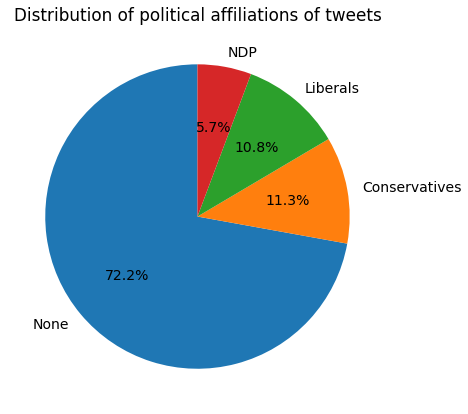

<Figure size 432x288 with 0 Axes>

In [56]:
mpl.rcParams['font.size'] = 14.0
plt.figure(figsize = [7,7])
plt.pie(tweet_party.values, labels=tweet_party.index, startangle=90, autopct='%.1f%%')
plt.title('Distribution of political affiliations of tweets')
plt.show()
plt.savefig('Distribution of political affiliations of tweets.png')

**Discussion:**

The majority of tweets do not affiliate to any of the parties, therefore NONE.
This may be because tweets have been extracted using general keywords.

For the rest of the data, the affiliation is as follows:
**Conservatives > Liberals > NDP**

Conservatives and liberals have almost equal affiliation in data (11.3 % & 10.8%) respectively.
This might also explain popularity of Liberals and conservatives over NDP (negative or positive)

**Data Processing**
Now, that we have cleaned specifically for Canadian election 2019 file, we can use the general cleaning function above

In [57]:
#repr(string)

In [58]:
data_election['tweets'] = data_election['tweets'].apply(lambda x: preprocess_text(x)).copy()
data_election[['tweets', 'text']].head()

,tweets,text
0,instead your suggestion about agree can not should not trust and government will protect woman to automony her body go that,"b""@RosieBarton So instead of your suggestion, how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Conservatives government will protect a woman's right to have automony over her body. Let's go with that. #cdnpoli #elxn43 #Canada #abortion"""
1,real station,"b""#AllWomanSpacewalk it's real!\n@Space_Station \n#EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 https://t.co/wgdXLksTbQ"""
2,going cost 94 billion the year justin,"b""#Brantford It's going to cost YOU $94 BILLION FOR THE NEXT 4 YEARS! ASK JUSTIN! #elxn43 #cdnpoli #Canada https://t.co/9DTLLd9972"""
3,cant decide should help,"b""#Canada #CanadaElection2019 #CanadaVotes \n#elxn43 \n\nCan't decide? This should help!\n\nhttps://t.co/UNe5J1tDJ6"""
4,sick amp tired having hard earned donated corporate welfare bum dont it is one many reason leave all care copps,"b""#Canada #taxpayers are sick &amp; tired of having their hard earned $ donated to corporate welfare bums that don't need it! This is only one of many reasons #TrudeauMustGo. @SNCLavalin can leave #Canada for all I care. @Sheila_Copps #SNCLavalinScandal #Election2019 #elxn43 #cdnpoli https://t.co/ywD7MAByKk"""


In [59]:
#replacing negative with 0 and positive with 1: just for convinient labelling 
data_election['sentiment'].replace('negative', 0, inplace = True)
data_election['sentiment'].replace('positive', 1, inplace = True)
data_election['sentiment'].head()

0    0
1    1
2    0
3    1
4    0
Name: sentiment, dtype: int64

## Word Cloud for Canadian Election tweets

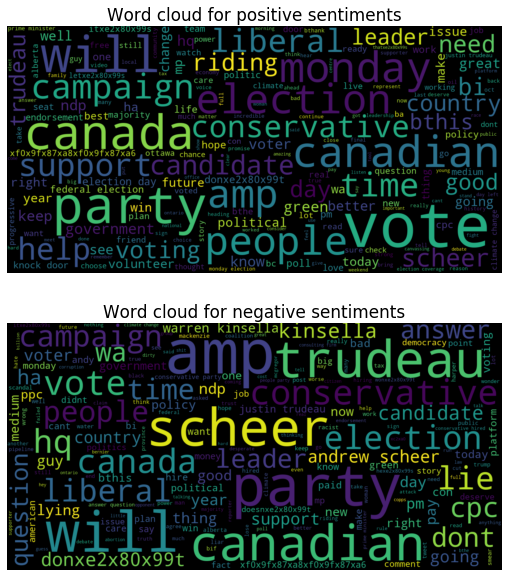

<Figure size 432x288 with 0 Axes>

In [60]:
#Word cloud for Positive Tweets
generic_tweets = data_election['tweets'][data_election['sentiment']==1]
tweets_string = []
for t in generic_tweets:
    tweets_string.append(t)
tweets_string = pd.Series(tweets_string).str.cat(sep=' ')


wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tweets_string)
fig, axes = plt.subplots(2, 1, figsize = (12,10))
axes[0].set_title('Word cloud for positive sentiments')
axes[0].imshow(wordcloud, interpolation="bilinear")
axes[0].axis("off")

#word cloud for negative tweets
generic_tweets = data_election['tweets'][data_election['sentiment'] == 0]
tweets_string = []
for t in generic_tweets:
    tweets_string.append(t)
tweets_string = pd.Series(tweets_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tweets_string)

axes[1].set_title('Word cloud for negative sentiments')
axes[1].imshow(wordcloud, interpolation="bilinear")
axes[1].axis("off")

plt.show()
plt.savefig('Word Clouds.png')

**Discussion:**
Apart from the common words like Canadian, canada, party, campaign:

We can observe liberal and conservatives related strings are quite prominent for both sentiments

1. From negative sentiments, kinsella seems to be highlight - He belonged to liberals party. Therefore, more of negative sentiments towards liberals might be because of Kinsella
2. Very few instances of NDP party, which again reflects less popularity of NDP among people. This is in accordance with the political affiliations distribution plot

In [61]:
tfidf_election = tfidf_vectorizer.transform(data_election['tweets'])
bow_election = count_vectorizer.transform(data_election['tweets'])

In [62]:
election_tweets = hstack([tfidf_election, bow_election])

In [63]:
label = data_election['sentiment']

# Model Implementation

Using Naive Bayes model for canadian election tweets to predict setiments and analysing the results

In [64]:
print("Accuracy for model Canadian Election data on Naive Bayes- Bag of words is", round(model_naive_bayes_bow.score(bow_election,label),2)*100 , "%")
predictions = model_naive_bayes_bow.predict(bow_election)
print ("Confusion matrix: \n", confusion_matrix(label,predictions,labels=[0, 1]))
print("Precision, recall and F1_score: \n", classification_report(label,predictions))

Accuracy for model Canadian Election data on Naive Bayes- Bag of words is 59.0 %
Confusion matrix: 
 [[474 532]
 [344 783]]
Precision, recall and F1_score: 
               precision    recall  f1-score   support

           0       0.58      0.47      0.52      1006
           1       0.60      0.69      0.64      1127

   micro avg       0.59      0.59      0.59      2133
   macro avg       0.59      0.58      0.58      2133
weighted avg       0.59      0.59      0.58      2133



**Results & Discussion:**

Accuracy for best model is 60 % and macro average f1-score is 0.59.

Given complete new data, model is performing well but not so good.
Since f1-score > 0.5 Using NLP, one can be certain of the overall sentiment polarity regarding Canadian Elections

recall for negative sentiments is 0.46 while for positive sentiments is 0.72. Therefore model predicts positive sentiments more correctly

However, performance can be improved by hyperparameter tuning - alpha - which is the smoothening parameter. 

In [67]:
liberals = data_election[data_election['party_label'] == 'Liberals']
label = liberals['sentiment']
liberals_tfidf = tfidf_vectorizer.transform(liberals['tweets'])
liberals_bow = count_vectorizer.transform(liberals['tweets'])
f_liberals = hstack([liberals_tfidf, liberals_bow])
y_test = liberals['sentiment'].to_numpy()
prediction_liberals = model_naive_bayes_bow.predict(liberals_bow)
y_test.shape

print("Accuracy for sentiments related to lierals' tweets: ",round(model_naive_bayes_bow.score(liberals_bow,y_test_4),4)*100, "%")
print ("Confusion matrix: \n", confusion_matrix(label,prediction_liberals,labels=[0, 1]))
print("Precision, recall and F1_score: \n", classification_report(label,prediction_liberals))

prediction_liberals_df = pd.DataFrame(prediction_liberals, columns = ['predict'])['predict'].value_counts()

#positive_counts and negative counts 
predict_pos_count = prediction_liberals_df[1]
predict_neg_count = prediction_liberals_df[0]

actual_liberals_df = pd.DataFrame(y_test, columns = ['actual'])['actual'].value_counts()

#postive_counts and negative counts
actual_pos_count = actual_liberals_df[1]
actual_neg_count = actual_liberals_df[0]


Accuracy for sentiments related to lierals' tweets:  52.61 %
Confusion matrix: 
 [[71 83]
 [26 50]]
Precision, recall and F1_score: 
               precision    recall  f1-score   support

           0       0.73      0.46      0.57       154
           1       0.38      0.66      0.48        76

   micro avg       0.53      0.53      0.53       230
   macro avg       0.55      0.56      0.52       230
weighted avg       0.61      0.53      0.54       230



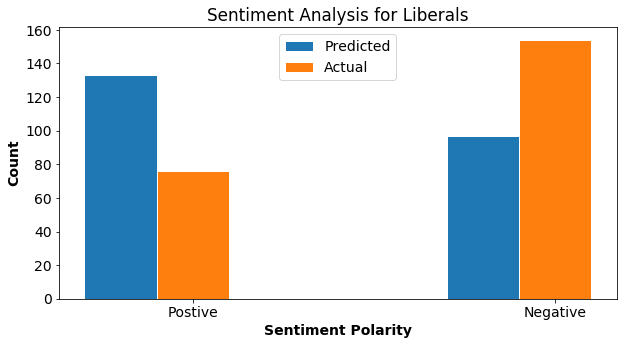

In [68]:
barWidth = 0.20
bars1 = [predict_pos_count, predict_neg_count]
bars2 = [actual_pos_count, actual_neg_count]

plt.figure(figsize = [10,5])

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]


plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='Predicted')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='Actual')

# Add xticks on the middle of the group bars
plt.xlabel('Sentiment Polarity', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Postive', 'Negative'])

plt.legend(loc='upper center')
plt.title('Sentiment Analysis for Liberals')
plt.show()


**Discussion:**
Specific to Liberals, the sentiment prediction is not good. It gives complete opposite picture. In reality, negative sentiments are more than positive sentiments. The model predicts that positive sentiments are more than negative. This can be misleading

In [69]:
conservatives = data_election[data_election['party_label'] == 'Conservatives']
label = conservatives['sentiment']
conservatives_tfidf = tfidf_vectorizer.transform(conservatives['tweets'])
conservatives_bow = count_vectorizer.transform(conservatives['tweets'])
f_conservatives = hstack([conservatives_tfidf, conservatives_bow])
y_test = conservatives['sentiment'].to_numpy()
prediction_conservatives = model_naive_bayes_bow.predict(conservatives_bow)
y_test.shape

print("Accuracy for sentiments related to conservatives' tweets: ", model_naive_bayes_bow.score(conservatives_bow,y_test)*100)
print ("Confusion matrix: \n", confusion_matrix(label,prediction_conservatives,labels=[0, 1]))
print("Precision, recall and F1_score: \n", classification_report(label,prediction_conservatives))


prediction_conservatives_df = pd.DataFrame(prediction_conservatives, columns = ['predict'])['predict'].value_counts()

#positive_counts and negative counts 
predict_pos_count = prediction_conservatives_df[1]
predict_neg_count = prediction_conservatives_df[0]

actual_conservatives_df = pd.DataFrame(y_test, columns = ['actual'])['actual'].value_counts()

#postive_counts and negative counts
actual_pos_count = actual_conservatives_df[1]
actual_neg_count = actual_conservatives_df[0]

Accuracy for sentiments related to conservatives' tweets:  52.892561983471076
Confusion matrix: 
 [[67 91]
 [23 61]]
Precision, recall and F1_score: 
               precision    recall  f1-score   support

           0       0.74      0.42      0.54       158
           1       0.40      0.73      0.52        84

   micro avg       0.53      0.53      0.53       242
   macro avg       0.57      0.58      0.53       242
weighted avg       0.63      0.53      0.53       242



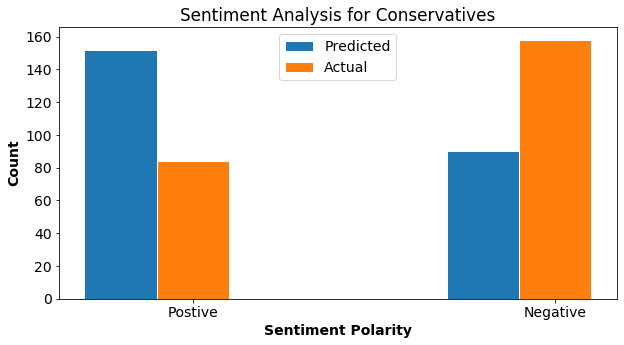

In [70]:
barWidth = 0.20
bars1 = [predict_pos_count, predict_neg_count]
bars2 = [actual_pos_count, actual_neg_count]

plt.figure(figsize = [10,5])

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]


plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='Predicted')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='Actual')

# Add xticks on the middle of the group bars
plt.xlabel('Sentiment Polarity', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Postive', 'Negative'])

plt.legend(loc='upper center')
plt.title('Sentiment Analysis for Conservatives')
plt.show()

**Discussion:**
Specific to Conservatives, the sentiment prediction is not good. It gives complete opposite picture. In reality, negative sentiments are more than positive sentiments. The model predicts that positive sentiments are more than negative. This can be misleading

Accuracy for conservatives is more than liberals

In [71]:
ndp = data_election[data_election['party_label'] == 'NDP']
label = ndp['sentiment']
ndp_tfidf = tfidf_vectorizer.transform(ndp['tweets'])
ndp_bow = count_vectorizer.transform(ndp['tweets'])
f_ndp = hstack([ndp_tfidf, ndp_bow])
y_test = ndp['sentiment'].to_numpy()
prediction_ndp = model_naive_bayes_bow.predict(ndp_bow)
y_test.shape

print("Accuracy for sentiments related to NDP tweets: ", model_naive_bayes_bow.score(ndp_bow,y_test)*100)
print ("Confusion matrix: \n", confusion_matrix(label,prediction_ndp,labels=[0, 1]))
print("Precision, recall and F1_score: \n", classification_report(label,prediction_ndp))

prediction_ndp_df = pd.DataFrame(prediction_ndp, columns = ['predict'])['predict'].value_counts()

#positive_counts and negative counts 
predict_pos_count = prediction_ndp_df[1]
predict_neg_count = prediction_ndp_df[0]

actual_ndp_df = pd.DataFrame(y_test, columns = ['actual'])['actual'].value_counts()

#postive_counts and negative counts
actual_pos_count = actual_ndp_df[1]
actual_neg_count = actual_ndp_df[0]

Accuracy for sentiments related to NDP tweets:  62.295081967213115
Confusion matrix: 
 [[12 22]
 [24 64]]
Precision, recall and F1_score: 
               precision    recall  f1-score   support

           0       0.33      0.35      0.34        34
           1       0.74      0.73      0.74        88

   micro avg       0.62      0.62      0.62       122
   macro avg       0.54      0.54      0.54       122
weighted avg       0.63      0.62      0.63       122



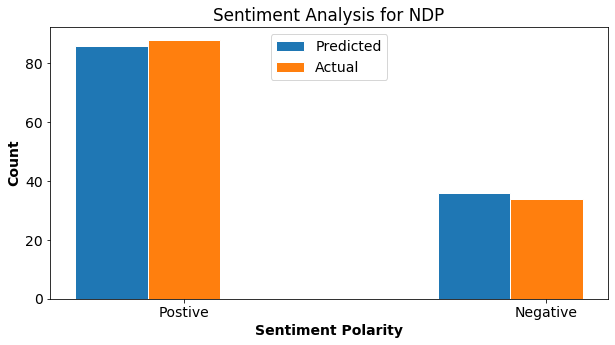

In [72]:
barWidth = 0.20
bars1 = [predict_pos_count, predict_neg_count]
bars2 = [actual_pos_count, actual_neg_count]

plt.figure(figsize = [10,5])

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]


plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='Predicted')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='Actual')

# Add xticks on the middle of the group bars
plt.xlabel('Sentiment Polarity', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Postive', 'Negative'])

plt.legend(loc='upper center')
plt.title('Sentiment Analysis for NDP')
plt.show()

**Discussion:**
Specific to NDP, results are better as compared to other parties. It gives clear picture of the sentiments. Although the samples are lesser for NDP, model gives good results.

**Results and discussion:**

**Actual result:** Number of seats won by parties: Liberals > Conservatives > NDP

**Comparison:**
Conservatives and liberals are popular parties in tweets. The number of negative sentiments are more for conservatives (though difference is not significant when compared with Liberals). The number of negative sentiments can are in allignment with the actual results (more negative sentiments, lesser seats). 

As seen in the analysis, NDP is not so popular party. (through political affiliations and word count). This is reflected in actual results as well. Of the three parties, NDP won the least number of tweets.

**Usefulness of NLP based analysis on tweets:**
NLP can be quite useful for parties as well as the general population during campaign:

1. It helps analyzing manifestos of parties.
2. Parties can decide their agenda based on the analysis on tweets - the public demands and sentiments can be analyzed 
3. Other parties can benefit from the public reaction towards the policies of one party. Other parties can propose a public-favored policy

Example: During Canadian election 2019, climate was major issue among the parties. It went viral due to the climate week ahead of polls. Parties took the advantage, analyzed what public demands and proposed various policies related to environment and climate

Text analytic are useful if they can be turned into objective data and meaningful conclusions

**Results of Analysis and interpretation:**
From the analysis of model - naive bayes - on Canadian Election data, we get accuracy for sentiment analysis as 60% and f1-score 0.59

The model is capable of overall sentiment prediction. Since recall of positive sentiment is more than negative sentiment class, model predicts positive class more. It can be said to be little biased. This may be due to the similar words in both kinds of tweets. 

**From public view point:**
1. NDP is less popular
2. Conservatives and liberals have almost equal negative sentiments and positive sentiments from public. (Positive ~ Negative)
3. Public holds more positive sentiments for NDP, than negative sentiments (Positive > negative)

**Improvements for models:**
1. Since there is repetition of words in positive sentiment tweets and negative sentiment tweets, better features should be used for analysis
2. Common words related to subject, which do not change the meaning of text should be removed along with stop words
3. Hyper-parameter tuning can be done on models: especially models like ensembles can perform way better if the hyper - parameters are tuned

In [73]:
df_negative = data_election[data_election['sentiment']==0]

In [74]:
df_negative['negative_reason'].value_counts(dropna = False)

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                51 
Women Reproductive right and Racism    45 
Climate Problem                        41 
Separation                             16 
Privilege                              12 
Healthcare                             5  
Healthcare and Marijuana               4  
Name: negative_reason, dtype: int64

**Combining few neagtive reasons categories:**

Welfare of people is a broad aspect that has impact over each individual and reasons like healthcare, climate (directly affects people and their next generation as well), women reproductive rights and racism, privilege and separation can be clubbed as a broader category of welfare

In [75]:
#combining the welfare related reason as one
#welfare = ['Economy', 'Separation', 'Privilege', 'Healthcare', 'Healthcare and Marijuana', 'Climate Problem', 'Women Reproductive right and Racism']
welfare = ['Healthcare', 'Healthcare and Marijuana', 'Women Reproductive right and Racism', 'Privilege', 'Separation', 'Climate Problem', 'Economy']
for word in welfare:
    df_negative['negative_reason'].replace(word, 'welfare', inplace = True)

df_negative['negative_reason'].value_counts()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Others       364
Scandal      270
Tell lies    198
welfare      174
Name: negative_reason, dtype: int64

In [77]:
tweet_negative_reasons = df_negative['negative_reason'].value_counts()

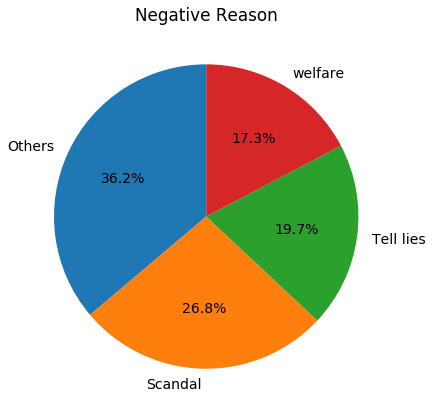

In [78]:
mpl.rcParams['font.size'] = 14.0
plt.figure(figsize = [7,7])
plt.pie(tweet_negative_reasons.values, labels=tweet_negative_reasons.index, startangle=90, autopct='%.1f%%')
plt.title('Negative Reason')
plt.show()

**Using WordtoVec as feature along with TFIDF and bag of words**


In [79]:
tokenized_sentences = [sentence.split() for sentence in df_negative['tweets']]

In [80]:

model = word2vec.Word2Vec(tokenized_sentences, size=500, min_count=1)

In [81]:
def buildWordVector(text, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    text = text.split(' ')
    for word in text:
        if word != '':
            vec += model[word].reshape((1, size))
            count += 1.
        if count != 0:
            vec /= count
    return vec

In [82]:
array_wordEmbedding = np.concatenate([buildWordVector(z, 500) for z in df_negative['tweets']])

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [83]:
array_wordEmbedding.shape

(1006, 500)

In [84]:
tfidf_df_negative = tfidf_vectorizer.transform(df_negative['tweets'])
bow_df_negative = count_vectorizer.transform(df_negative['tweets'])
f_df_negative = hstack([tfidf_df_negative,bow_df_negative,array_wordEmbedding ])

In [85]:
le = LabelEncoder()
df_negative.loc[:,'negative_reason_label'] = le.fit_transform(df_negative['negative_reason'])

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [86]:
df_negative.head()

,sentiment,negative_reason,text,tweets,party_label,negative_reason_label
0,0,welfare,"b""@RosieBarton So instead of your suggestion, how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Conservatives government will protect a woman's right to have automony over her body. Let's go with that. #cdnpoli #elxn43 #Canada #abortion""",instead your suggestion about agree can not should not trust and government will protect woman to automony her body go that,Conservatives,3
2,0,welfare,"b""#Brantford It's going to cost YOU $94 BILLION FOR THE NEXT 4 YEARS! ASK JUSTIN! #elxn43 #cdnpoli #Canada https://t.co/9DTLLd9972""",going cost 94 billion the year justin,None,3
4,0,welfare,"b""#Canada #taxpayers are sick &amp; tired of having their hard earned $ donated to corporate welfare bums that don't need it! This is only one of many reasons #TrudeauMustGo. @SNCLavalin can leave #Canada for all I care. @Sheila_Copps #SNCLavalinScandal #Election2019 #elxn43 #cdnpoli https://t.co/ywD7MAByKk""",sick amp tired having hard earned donated corporate welfare bum dont it is one many reason leave all care copps,Liberals,3
5,0,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - #BlastFromThePast - In 2012 #Conservatives introduced the end of the long-gun registry even though all heads of police across Canada and victims' groups objected for crime control and public safety! #GunLobby https://t.co/WgZKMSQ4wa""",fact 2012 introduced end the longgun registry though head police canada victim group objected crime control public safety,Conservatives,0
8,0,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don't Make America's Mistakes | Full Frontal on TBS https://t.co/PhU4jHxnMF via @YouTube""",canada dont america mistake full frontal tb,None,0


In [87]:
#random_state shuffles while splitting
X_train, X_test, y_train, y_test = train_test_split(f_df_negative, df_negative['negative_reason_label'], test_size = 0.3, random_state = 42)

In [88]:
model_name = 'Logistic_regression'
model_logistic_regression = LogisticRegression(solver = 'sag',penalty = 'l2', multi_class = 'multinomial', max_iter = 3000)
model_logistic_regression.fit(X_train, y_train)
print("Accuracy for model- ", model_name, "is", round(model_logistic_regression.score(X_test, y_test),2)*100 , "%")
predictions = model_logistic_regression.predict(X_test)
print ("Confusion matrix: \n", confusion_matrix(y_test,predictions,labels=[0, 1, 2, 3]))
classification_report_ = classification_report(y_test,predictions, output_dict=True)
class_report = pd.DataFrame(classification_report_).transpose()

#since the data is not equally distributed among classes, considering micro-average f1-score as evaluation metrics
f1_score_lr_negative = class_report.loc['micro avg','f1-score']
print("Precision, recall and F1_score: \n", classification_report(y_test,predictions))


Accuracy for model-  Logistic_regression is 47.0 %
Confusion matrix: 
 [[72 25  8 14]
 [28 38  3  4]
 [31 11 18  4]
 [16 12  5 13]]
Precision, recall and F1_score: 
               precision    recall  f1-score   support

           0       0.49      0.61      0.54       119
           1       0.44      0.52      0.48        73
           2       0.53      0.28      0.37        64
           3       0.37      0.28      0.32        46

   micro avg       0.47      0.47      0.47       302
   macro avg       0.46      0.42      0.43       302
weighted avg       0.47      0.47      0.46       302



In [89]:
model_name = 'Random Forest Classifier'
model_random_forest = RandomForestClassifier(n_estimators=100)
model_random_forest.fit(X_train, y_train)
print("Accuracy for model- ", model_name, "is", round(model_random_forest.score(X_test, y_test),2)*100 , "%")
predictions = model_random_forest.predict(X_test)
classification_report_ = classification_report(y_test,predictions, output_dict=True)
class_report = pd.DataFrame(classification_report_).transpose()

#since the data is not equally distributed among classes, considering micro-average f1-score as evaluation metrics
f1_score_rf_negative = class_report.loc['micro avg','f1-score']


print ("Confusion matrix: \n", confusion_matrix(y_test,predictions,labels=[0, 1, 2, 3]))
print("Precision, recall and F1_score: \n", classification_report(y_test,predictions))

Accuracy for model-  Random Forest Classifier is 40.0 %
Confusion matrix: 
 [[82 27  5  5]
 [38 25  4  6]
 [32 17 11  4]
 [20 18  4  4]]
Precision, recall and F1_score: 
               precision    recall  f1-score   support

           0       0.48      0.69      0.56       119
           1       0.29      0.34      0.31        73
           2       0.46      0.17      0.25        64
           3       0.21      0.09      0.12        46

   micro avg       0.40      0.40      0.40       302
   macro avg       0.36      0.32      0.31       302
weighted avg       0.39      0.40      0.37       302



In [91]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

param = {'eta': 0.3, 'max_depth': 3,'objective': 'multi:softprob','num_class': 4}
steps = 50  # The number of training iterations


model_name = 'XGBoost'
model_XGBoost = xgb.train(param, D_train, steps)
#model_XGBoost.fit(f_train, y_train)

#evaluation on test

#since the data is not equally distributed among classes, considering micro-average f1-score as evaluation metrics

predict = model_XGBoost.predict(D_test)
predictions = np.asarray([np.argmax(line) for line in predict])
precision = precision_score(y_test, predictions, average='micro')
recall= recall_score(y_test, predictions, average='micro')
f1_score_xgb_negative = 2*(precision*recall)/(precision+recall)
accuracy_test_xgb= accuracy_score(y_test, predictions)
print("Precision on test set = {}".format(precision))
print("Recall on test set = {}".format(recall))
print("F1 Score on test set = {}".format(f1_score_xgb_negative))
print("Accuracy on test set = {}".format(accuracy_test_xgb))
#test_accuracy.append(accuracy_test)
#test_f_measure.append(f1_score_test)



Precision on test set = 0.4602649006622517
Recall on test set = 0.4602649006622517
F1 Score on test set = 0.4602649006622517
Accuracy on test set = 0.4602649006622517


**Results & Discussion:**
Considering micro-average f1-score here because classes are not equally distributed for negative reasons

Based on the micro-avg f1-score, performace of models for reasoning of negative sentiment is:
**Random Forest < Logistic Regression < XGBoost**

Model has not performed well. It may be due to:
1. Not enough number of samples for certain classes. Like 'Others' has 364 samples (highest) while welfare has only 174 samples, out of which only 70% are used for training. This under-represented class may lead to improper training of model
2. Model may be too complex because of the number of features. 
3. Since many words are repeating in the tweets' text..for all the classes, model is not able to classify correctly on extracted features: TFIDF, Bag of words and word to vec. e.g: words like Canada, reason, amp, will etc appear in 'welfare' as well as 'other' class

Ways to improve model performance:
1. Constrain classification: where each example is labeled with a set of constraints relating multiple classes. Each such constraint specifies the relative order of two classes for this example. The goal is to learn a classifier consistent with these constraints. Learning is made possible by a simple transformation mapping each example into a set of examples (one for each constraint) and the application of any binary classifier on the mapped examples
2. Oversampling of under-represented classes by re-evaluation of negative reason using string matching techniques. This can increase samples in 'welfare'/ 'tell lies' class


In [105]:
f1_score_negative = [f1_score_lr_negative, f1_score_rf_negative, f1_score_xgb_negative]
col_neg = ['Logistic Regression', 'Random Forest', 'XGBoost']


> Exploratory Analysis for model results and word counts in two files


> Improve performance of model by tuning its hyperparameter

**Number of words in Generic Data tweets (each sample)**

In [ ]:
data['word_count'] = data['tweets'].apply(lambda x: len(x.split()))

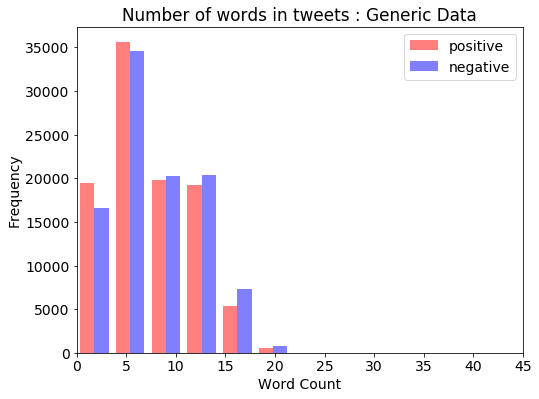

In [93]:
x = data['word_count'][data['class'] == 1] #positive
y = data['word_count'][data['class'] == 0] #negative
plt.figure(figsize=(8,6))
plt.xlim(0,45)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')
plt.title('Number of words in tweets : Generic Data')
#plt.savefig('Number of words in tweet_generic.png')
plt.show()

From the graph above, most sentences fall between 0-15 words but it’s fair to say that majority of text on twitter falls between 1 and 20 words. This is no wonder considering that twitter has a limit of how many characters one can use in a message. 280 characters is the limit at the time of this writing.
In all, it looks like 1–20 words covers more than 80% of all sentences which makes this dataset set a good training candidate.
There are more positive sentences with 5 words or less than there are negative ones which does not seem like a big enough difference to cause any concern at the moment.

In [94]:
data_election['word_count'] = data_election['tweets'].apply(lambda x: len(x.split()))

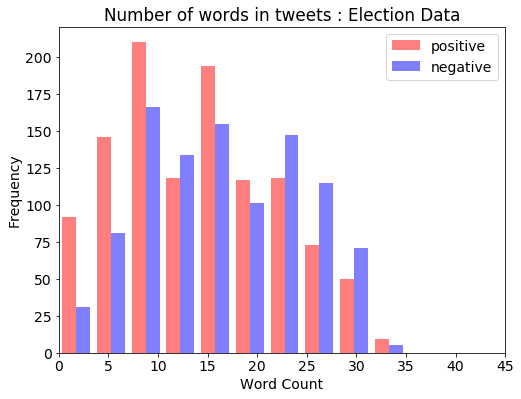

In [96]:
x = data_election['word_count'][data_election['sentiment'] == 1] #positive
y = data_election['word_count'][data_election['sentiment'] == 0] #negative
plt.figure(figsize=(8,6))
plt.xlim(0,45)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')
plt.title('Number of words in tweets : Election Data')
#plt.savefig('Number of words in tweet_generic.png')
plt.show()

From the graph above, most sentences fall between 0-25 words 
In all, it looks like 5–15 words covers more than 80% of all sentences which is similar to the training dataset

**Plot for models result - Part 3**

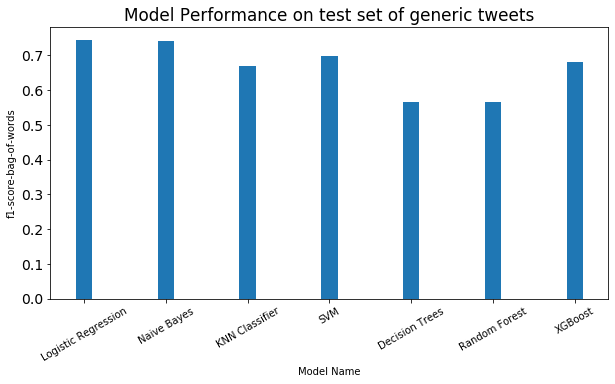

In [104]:
index = np.arange(len(col))
plt.figure(figsize = (10,5))
plt.bar(index, f1_score_bow, width = 0.2)
plt.xlabel('Model Name', fontsize=10)
plt.ylabel('f1-score-bag-of-words', fontsize=10)
plt.xticks(index, col, fontsize=10, rotation=30)
plt.title('Model Performance on test set of generic tweets')
plt.show()

Therefore, Naive Bayes and Logisitic Regression perform better than all others

**Plot for models result - Part 4 negative- tweets**

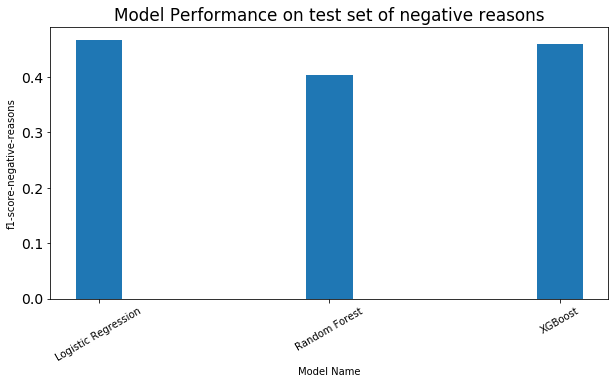

In [106]:
index = np.arange(len(col_neg))
plt.figure(figsize = (10,5))
plt.bar(index, f1_score_negative, width = 0.2)
plt.xlabel('Model Name', fontsize=10)
plt.ylabel('f1-score-negative-reasons', fontsize=10)
plt.xticks(index, col_neg, fontsize=10, rotation=30)
plt.title('Model Performance on test set of negative reasons')
plt.show()

Therefore, XGBoost and Logistic regression perform approximate same, while random forest doesn't perform so well

In [110]:
X = data['tweets']
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [111]:
bow_train.shape

(140000, 2000)

In [112]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':[1, 10,20,30,100], 'max_leaf_nodes':[30,40,50,100,150]}
tune = GridSearchCV(model_decision_tree_bow, parameters, cv=5)
tune.fit(bow_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=30,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 10, 20, 30, 100], 'max_leaf_nodes': [30, 40, 50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [121]:
#tune.cv_results_

In [114]:
tune.best_params_

{'max_depth': 100, 'max_leaf_nodes': 150}

In [118]:
predictions = tune.predict(bow_test)

In [120]:
tune.score(bow_test,y_test)*100

70.60499999999999

In [119]:
print ("Confusion matrix: \n", confusion_matrix(y_test,predictions,labels=[0, 1]))
print("Precision, recall and F1_score: \n", classification_report(y_test,predictions))

Confusion matrix: 
 [[19534 10393]
 [ 7244 22829]]
Precision, recall and F1_score: 
               precision    recall  f1-score   support

           0       0.73      0.65      0.69     29927
           1       0.69      0.76      0.72     30073

   micro avg       0.71      0.71      0.71     60000
   macro avg       0.71      0.71      0.71     60000
weighted avg       0.71      0.71      0.71     60000



Without tuning, Accuracy on training Set = 61 % and f1-score (macro-avg) = 0.567

Tuning has increased the accuracy on traing set by 9% and f1-score macro average by approx 0.15

# THE END